In [1]:
# Data processing tools: pandas and numpy
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

# Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC

# Regressors
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.svm import SVR

# Visualization
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Preprocessing
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Model selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle

from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve

# Data imputation
!pip install miceforest
!pip install --upgrade scipy
import miceforest as mf

# Others
import time
import warnings
warnings.filterwarnings('ignore')

Defaulting to user installation because normal site-packages is not writeable


# Parameters of the experiments

In [42]:
# Dataset parameters
regression = True
dataset_number = 0

# Noise mode
# 0 - no noise
# 1 - AWGN noise
# 2 - replacements
noise_mode = 2
SNR = 10
changing_probability = 0.2

# Dropping mode
# 0 - no dropping
# 1 - MCAR
# 2 - MAR
# 3 - NMAR
dropping_mode = 1
dropping_probability = 0.3

# Imputation mode
# 0 - dropping
# 1 - filling with 0
# 2 - filling with mean
# 3 - filling with median
# 4 - filling by MICE
# 5 - filling by kNN
imputation_mode = 3

# Reproducibility parameters
random_state = 0
test_size = 0.25

# Visualization parameters
get_feature_importance = True
get_best_models = True

# Read dataset

In [43]:
directory = "Datasets/"

datasets_regression = [
    "productivity_prediction(R)",
    "bias_correction_temp_forecast(R)",
#     "air_quality(R)",
]

datasets_classification = [
    "census_income(C)",
    "mushroom(C)",
    "ozone_level_detection(C)",
    "polish_companies_bankruptcy(C)",
#     "diabetes_130-US(C)",
]

if regression:
    datasets = datasets_regression
else:
    datasets = datasets_classification
    
dataset = datasets[dataset_number]

df = pd.read_csv(directory+dataset+"/"+dataset+"_processed.csv")
df.head()

,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,Target
0,Quarter1,sweing,Thursday,8,0.8,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,Quarter1,sweing,Thursday,11,0.8,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
2,Quarter1,sweing,Thursday,12,0.8,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,Quarter1,sweing,Thursday,6,0.8,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382
4,Quarter1,sweing,Thursday,7,0.8,25.90,984.0,6720,38,0.0,0,0,56.0,0.800125


# Add noise

In [44]:
SNR_times = 10 ** (SNR / 10.)

np.random.seed(random_state)

noised = df.copy()

if noise_mode == 1:
    continuous_features =  list(df.columns[df.dtypes != "object"])
    signal_powers = (abs(df[continuous_features]) ** 2).mean()

    for feature in continuous_features:
        if feature != 'Target':
            signal_power = signal_powers[feature]
            noise_power = signal_power / SNR_times
            noise = np.random.normal(0,1,df.shape[0])
            noise *= np.sqrt(noise_power)
            noised[feature] += noise
elif noise_mode == 2:
    for i in range(df.shape[1]):
        if df.columns[i] != 'Target':
            for j in range(df.shape[0]):
                if np.random.uniform() < changing_probability:
                        if df.dtypes[i] == 'object':
                            noised.iloc[j, i] = np.random.choice(df.iloc[:,i].unique())
                        else:
                            lim = (df.iloc[:,i].min(), df.iloc[:,i].max())
                            noised.iloc[j, i] = np.array(np.random.uniform(*lim), dtype=df.dtypes[i])

df = noised

# Drop values

In [5]:
if dropping_mode == 1:
    for i in range(df.shape[1]):
        if df.columns[i] != 'Target':
            for j in range(df.shape[0]):
                if np.random.uniform() < dropping_probability:
                    df.iloc[j, i] = None

# Impute data

In [6]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   station           5266 non-null   float64
 1   Present_Tmax      5266 non-null   float64
 2   Present_Tmin      5287 non-null   float64
 3   LDAPS_RHmin       5345 non-null   float64
 4   LDAPS_RHmax       5292 non-null   float64
 5   LDAPS_Tmax_lapse  5283 non-null   float64
 6   LDAPS_Tmin_lapse  5293 non-null   float64
 7   LDAPS_WS          5241 non-null   float64
 8   LDAPS_LH          5333 non-null   float64
 9   LDAPS_CC1         5256 non-null   float64
 10  LDAPS_CC2         5286 non-null   float64
 11  LDAPS_CC3         5223 non-null   float64
 12  LDAPS_CC4         5239 non-null   float64
 13  LDAPS_PPT1        5289 non-null   float64
 14  LDAPS_PPT2        5366 non-null   float64
 15  LDAPS_PPT3        5244 non-null   float64
 16  LDAPS_PPT4        5289 non-null   float64


In [7]:
if imputation_mode == 0:
    filled = df.dropna()
elif imputation_mode == 1:
    filled = df.fillna(0)
elif imputation_mode == 2:
    filled = df.copy()

    categorical_features = list(df.columns[df.dtypes == "object"])
    continuous_features =  list(df.columns[df.dtypes != "object"])

    for feature in categorical_features:
        filled[feature].fillna(filled[feature].value_counts().index[0], inplace=True)
    for feature in continuous_features:
        filled[feature].fillna(filled[feature].mean(), inplace=True)
elif imputation_mode == 3:
    filled = df.copy()

    categorical_features = list(df.columns[df.dtypes == "object"])
    continuous_features =  list(df.columns[df.dtypes != "object"])

    for feature in categorical_features:
        filled[feature].fillna(filled[feature].value_counts().index[0], inplace=True)
    for feature in continuous_features:
        filled[feature].fillna(filled[feature].median(), inplace=True)
elif imputation_mode == 4:
    kds = mf.ImputationKernel(
      df,
      datasets=1,
      save_all_iterations=True,
      random_state=random_state
    )

    kds.mice(1) # or 5

    filled = kds.complete_data(dataset=0, inplace=False)
        
df = filled

In [8]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5643 entries, 0 to 5642
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Target                    5643 non-null   object
 1   cap-shape                 5643 non-null   object
 2   cap-surface               5643 non-null   object
 3   cap-color                 5643 non-null   object
 4   bruises                   5643 non-null   object
 5   odor                      5643 non-null   object
 6   gill-attachment           5643 non-null   object
 7   gill-spacing              5643 non-null   object
 8   gill-size                 5643 non-null   object
 9   gill-color                5643 non-null   object
 10  stalk-shape               5643 non-null   object
 11  stalk-root                5643 non-null   object
 12  stalk-surface-above-ring  5643 non-null   object
 13  stalk-surface-below-ring  5643 non-null   object
 14  stalk-color-above-ring  

# Train-test split and preprocessing

In [17]:
if regression:
    y = df['Target']
else:
    encoder = preprocessing.LabelEncoder()
    y = encoder.fit_transform(df['Target'])

X = pd.get_dummies(df.drop('Target', axis = 1), drop_first = False)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = random_state)

In [18]:
# Models used
if regression:
    models = [
        DecisionTreeRegressor(random_state = random_state),
        SVR(),
        RandomForestRegressor(random_state = random_state, n_jobs = -1),
        ExtraTreesRegressor(random_state = random_state, n_jobs = -1),
    ]
else:
    models = [
        DecisionTreeClassifier(random_state = random_state),
        LinearSVC(random_state = random_state),
        RandomForestClassifier(random_state = random_state, n_jobs = -1),
        ExtraTreesClassifier(random_state = random_state, n_jobs = -1),
    ]

# Parameters grid
grid_search_parameters = {
    'n_estimators': list(range(10,100,30)),
    'max_depth': [3, 5],
    'C': np.logspace(-3,3,7),
    'kernel': ['poly', 'rbf'], 
#     'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
          }

DecisionTreeClassifier  best with  {'decisiontreeclassifier__max_depth': 5}
LinearSVC  best with  {'linearsvc__C': 0.1}
RandomForestClassifier  best with  {'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 40}
ExtraTreesClassifier  best with  {'extratreesclassifier__max_depth': 5, 'extratreesclassifier__n_estimators': 70}


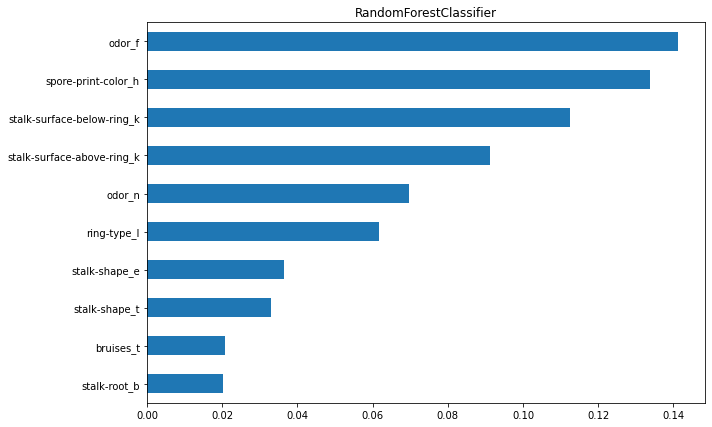

,Models,Test score
0,DecisionTreeClassifier,0.92
1,LinearSVC,0.97
2,RandomForestClassifier,0.92
3,ExtraTreesClassifier,0.90


In [29]:
test_scores = []

def getkeys(dict): 
    return [*dict]

for model in models:
    # Intersection of keys for GridSearchCV
    intersection_keys = model.get_params().keys() & grid_search_parameters.keys()
    parameters_grid = {}
    for key in intersection_keys:
        parameters_grid[key] = grid_search_parameters[key]
 
    pln = make_pipeline(StandardScaler(), model)

    pipeline_params_grid = {}
    for i in range(len(parameters_grid)):
        pipeline_params_grid[str(pln.steps[1][0]) + '__' + str(getkeys(parameters_grid)[i])] = parameters_grid[str(getkeys(parameters_grid)[i])]    

    if regression:
        scoring = 'neg_mean_absolute_percentage_error'
    else:
        scoring = 'f1_micro'
        
    gcv = GridSearchCV(pln, pipeline_params_grid, scoring = scoring, cv = 3,
                       n_jobs = -1, refit = True)
    gcv.fit(X_train, y_train)
    if get_best_models:
        print(model.__class__.__name__, ' best with ', gcv.best_params_)
        
    # Feature importances
    if get_feature_importance and model.__class__.__name__ == 'RandomForestClassifier':
        fimp = pd.Series(gcv.best_estimator_[1].feature_importances_, index = X_train.columns)
        fimp.nlargest(10).sort_values(ascending = True).plot.barh(figsize = (10, 7),
                                                                  title = model.__class__.__name__)
    # Calculate score
    if regression:
        test_scores.append(np.round(mape(y_test, gcv.best_estimator_.predict(X_test)), 2))
    else:
        test_scores.append(np.round(f1_score(y_test, gcv.best_estimator_.predict(X_test)), 2))

# print('\n The most important features:')
# print(fimp.nlargest(10))
plt.show()

scores = pd.DataFrame({'Models': [model.__class__.__name__ for model in models],
            'Test score': test_scores
})

scores